# World Health Organization Suicide Rate Prediction Project

## PSTAT135 Final Project, Winter 2019

### Bryan Wang (9606997)
### Carrie Yan (9497124)
### Leyi Zhang (9990532)

In [1]:
# import pyspark modules
import os
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql import types as typ     # for datatype conversion
from pyspark.sql import functions as F  # for col() function
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sc = SparkContext.getOrCreate()
sqlCtx = SQLContext(sc)

# Data Import and Preprocessing

## Imputing, Bining and Filtering

In [2]:
#read in dataset
suicide = pd.read_csv('master.csv')

In [3]:
df = sqlCtx.createDataFrame(suicide)

In [4]:
#rename in case of name sensitivity
df = df.withColumnRenamed("suicides/100k pop", "suicide_100k_pop") \
.withColumnRenamed("gdp_per_capita ($)", "gdp_per_capita")

In [5]:
df.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: long (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: long (nullable = true)
 |-- population: long (nullable = true)
 |-- suicide_100k_pop: double (nullable = true)
 |-- country-year: string (nullable = true)
 |-- HDI for year: double (nullable = true)
 |--  gdp_for_year ($) : string (nullable = true)
 |-- gdp_per_capita: long (nullable = true)
 |-- generation: string (nullable = true)



In [6]:
df.count()

27820

In [7]:
df.select(['age','year','suicide_100k_pop']).show(5)

+-----------+----+----------------+
|        age|year|suicide_100k_pop|
+-----------+----+----------------+
|15-24 years|1987|            6.71|
|35-54 years|1987|            5.19|
|15-24 years|1987|            4.83|
|  75+ years|1987|            4.59|
|25-34 years|1987|            3.28|
+-----------+----+----------------+
only showing top 5 rows



In [8]:
df.cache()

DataFrame[country: string, year: bigint, sex: string, age: string, suicides_no: bigint, population: bigint, suicide_100k_pop: double, country-year: string, HDI for year: double,  gdp_for_year ($) : string, gdp_per_capita: bigint, generation: string]

In [9]:
#Describe major attributions
df.describe(['suicides_no','population','suicide_100k_pop', 'gdp_per_capita',' gdp_for_year ($) ']).show()
    #suicide/100k pop is optimal than suicides_no
    #problem with the data type of gdp_for_year

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|       suicides_no|        population|  suicide_100k_pop|    gdp_per_capita| gdp_for_year ($) |
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|             27820|             27820|             27820|             27820|             27820|
|   mean|242.57440690150972|1844793.6173975556|12.816097411933846|16866.464414090584|              null|
| stddev| 902.0479168336386|3911779.4417563654|18.961511014503152|18887.576472205557|              null|
|    min|                 0|               278|               0.0|               251| 1,002,219,052,968|
|    max|             22338|          43805214|            224.97|            126352|       997,007,926|
+-------+------------------+------------------+------------------+------------------+------------------+



In [10]:
#compute correlation
df.corr('suicide_100k_pop','gdp_per_capita')

0.0017851337973438972

In [11]:
# compute correlation between all numeric features
features_numeric = ['suicides_no','population','suicide_100k_pop', 'gdp_per_capita']

n_numeric = len(features_numeric)
corr = []

for i in range(0, n_numeric):
 temp = [None] * i

 for j in range(i, n_numeric):
     temp.append(df.corr(features_numeric[i], features_numeric[j]))
 corr.append(temp)

In [12]:
corr

[[1.0, 0.6161622675219296, 0.3066044512677847, 0.06132974884024606],
 [None, 1.0, 0.008284973053478351, 0.08150985822280572],
 [None, None, 1.0, 0.0017851337973438972],
 [None, None, None, 1.0]]

In [13]:
df.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: long (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: long (nullable = true)
 |-- population: long (nullable = true)
 |-- suicide_100k_pop: double (nullable = true)
 |-- country-year: string (nullable = true)
 |-- HDI for year: double (nullable = true)
 |--  gdp_for_year ($) : string (nullable = true)
 |-- gdp_per_capita: long (nullable = true)
 |-- generation: string (nullable = true)



## Feature Engineering

In [14]:
import pyspark.mllib.stat as st
import numpy as np
from pyspark.sql.functions import col, asc

In [15]:
#feature transform: grouping countries into regions
Africa = ["Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cameroon","Cabo Verde", "Cape Verde",
          "Central African Republic", "Chad", "Comoros", "Côte d’Ivoire", "Democratic Republic of the Congo",
          "Equatorial Guinea", "Eritrea", "Ethiopia", "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau",
          "Kenya", "Lesotho", "Liberia", "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Mozambique",
          "Namibia", "Niger", "Nigeria", "Republic of the Congo", "Rwanda", "Sao Tome and Principe", "Senegal", 
          "Seychelles", "Sierra Leone", "South Africa", "Swaziland", "Togo", "Uganda", "United Republic of Tanzania",
          "Zambia", "Zimbabwe"]
Americas = ["Antigua and Barbuda", "Aruba","Argentina", "Bahamas", "Barbados", "Belize", "Bolivia (Plurinational State of)", 
            "Brazil", "Canada", "Chile", "Colombia", "Costa Rica", "Cuba", "Dominica", "Dominican Republic", "Ecuador",
            "El Salvador", "Grenada", "Guatemala", "Guyana", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama",
            "Paraguay", "Peru","Puerto Rico", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and Grenadines", "Suriname", 
            "Trinidad and Tobago", "United States", "Uruguay", "Venezuela (Bolivarian Republic of)"]
SouthEastAsia = ["Bangladesh", "Bhutan", "Democratic People’s Republic of Korea", "India", "Indonesia", "Maldives", "Myanmar",
                 "Nepal", "Sri Lanka", "Thailand", "Timor-Leste"]
European = ["Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria",
            "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece", 
            "Hungary", "Iceland", "Ireland", "Israel", "Italy", "Kazakhstan", "Kyrgyzstan", "Latvia", "Lithuania", "Luxembourg",
            "Malta", "Monaco", "Montenegro", "Netherlands", "Norway", "Poland", "Portugal", "Republic of Moldova", "Romania",
            "Russian Federation", "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Tajikistan",
            "The former Yugoslav Republic of Macedonia", "Turkey", "Turkmenistan", "Ukraine", "United Kingdom", "Uzbekistan"]
EasternMediterranean = ["Afghanistan", "Bahrain", "Djibouti", "Egypt", "Iran (Islamic Republic of)", "Iraq", "Jordan", 
                        "Kuwait", "Lebanon", "Libyan Arab Jamahiriya", "Morocco", "Oman", "Pakistan", "Qatar", "Saudi Arabia",
                        "Somalia", "Sudan", "Syrian Arab Republic", "Tunisia", "United Arab Emirates", "Yemen"]
WesternPacific = ["Australia", "Brunei Darussalam", "Cambodia", "China", "Cook Islands", "Fiji", "Japan", "Kiribati", 
                  "Lao People’s Democratic Republic", "Malaysia", "Marshall Islands", "Micronesia (Federated States of)", 
                  "Mongolia", "Nauru", "New Zealand", "Niue", "Palau", "Papua New Guinea", "Philippines", "Republic of Korea",
                  "Samoa", "Singapore", "Solomon Islands", "Taiwan", "Tonga", "Tuvalu", "Vanuatu", "Vietnam","Macau"]

In [16]:
df_processed = df.withColumn('region', F.when(F.col('country').isin(Africa), 'Africa')\
.when(F.col('country').isin(Americas), 'Americas') \
.when(F.col('country').isin(SouthEastAsia), 'SouthEastAsia')\
.when(F.col('country').isin(European), 'European')\
.when(F.col('country').isin(WesternPacific ), 'WesternPacific ')\
.when(F.col('country').isin(EasternMediterranean), 'EasternMediterranean'))                                                    

In [17]:
df_processed.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: long (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: long (nullable = true)
 |-- population: long (nullable = true)
 |-- suicide_100k_pop: double (nullable = true)
 |-- country-year: string (nullable = true)
 |-- HDI for year: double (nullable = true)
 |--  gdp_for_year ($) : string (nullable = true)
 |-- gdp_per_capita: long (nullable = true)
 |-- generation: string (nullable = true)
 |-- region: string (nullable = true)



# Data Preparation

In [18]:
#Keep the selected features for modeling part
df_trimmed = df_processed.select(["suicide_100k_pop",
                "population",
                "year",
                "gdp_per_capita",
                "sex",                              
                "age",
                "region",                 
                "generation"])

In [19]:
df_trimmed.printSchema()

root
 |-- suicide_100k_pop: double (nullable = true)
 |-- population: long (nullable = true)
 |-- year: long (nullable = true)
 |-- gdp_per_capita: long (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- region: string (nullable = true)
 |-- generation: string (nullable = true)



In [20]:
#Create pipeline for data preparation
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

cols = ["sex", "age", "generation","region"]

indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in cols
]

encoders = [
    OneHotEncoder(
        inputCol=indexer.getOutputCol(),
        outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

assembler = VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders],
    outputCol="features"
)


pipeline = Pipeline(stages=indexers + encoders + [assembler])

In [21]:
allData = pipeline.fit(df_trimmed).transform(df_trimmed)

In [22]:
allData = allData.withColumn('label', F.col('suicide_100k_pop'))

In [23]:
allData.printSchema()

root
 |-- suicide_100k_pop: double (nullable = true)
 |-- population: long (nullable = true)
 |-- year: long (nullable = true)
 |-- gdp_per_capita: long (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- region: string (nullable = true)
 |-- generation: string (nullable = true)
 |-- sex_indexed: double (nullable = false)
 |-- age_indexed: double (nullable = false)
 |-- generation_indexed: double (nullable = false)
 |-- region_indexed: double (nullable = false)
 |-- sex_indexed_encoded: vector (nullable = true)
 |-- age_indexed_encoded: vector (nullable = true)
 |-- generation_indexed_encoded: vector (nullable = true)
 |-- region_indexed_encoded: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)



## Data Spliting for Train, Test Datasets

In [24]:
train_data, test_data = allData.randomSplit([0.8,0.2], seed=123)

In [25]:
print('count_total={},count_train={},count_test={}'.format(allData.count(),train_data.count(),test_data.count()))


count_total=27820,count_train=22253,count_test=5567


# Exploratory data analysis

In [26]:
# compute distribution of a selected feature
allData.groupBy('region').count().show()

+--------------------+-----+
|              region|count|
+--------------------+-----+
|            European|14042|
|              Africa|  850|
|       SouthEastAsia|  586|
|            Americas| 9214|
|EasternMediterranean|  838|
|     WesternPacific | 2290|
+--------------------+-----+



In [28]:
# compute distribution of a selected feature
allData.groupBy('year').count().show(10)

+----+-----+
|year|count|
+----+-----+
|2007| 1032|
|1988|  588|
|2014|  936|
|1986|  576|
|2012|  972|
|1991|  768|
|2016|  160|
|1994|  816|
|1987|  648|
|1999|  996|
+----+-----+
only showing top 10 rows



In [29]:
# compute distribution of a selected feature
allData.groupBy('sex').count().show()

+------+-----+
|   sex|count|
+------+-----+
|female|13910|
|  male|13910|
+------+-----+



In [45]:
import pyspark.mllib.stat as st

In [46]:
numeric_cols = ["sex_indexed",
                "age_indexed",
                "population",                              
                "gdp_per_capita"]

In [47]:
numeric_rdd = allData \
             .select(numeric_cols) \
             .rdd \
             .map(lambda row: [e for e in row])

In [48]:
# Use MLlib package for compute stats on columns
mllib_stats = st.Statistics.colStats(numeric_rdd)

In [49]:
# extract some stats, zip and print mean, sd
for col, m, v in zip(numeric_cols,
                     mllib_stats.mean(),
                     mllib_stats.variance()):
 print('{0}: \t{1:.2f} \t {2:.2f}'.format(col, m, np.sqrt(v)))

sex_indexed: 	0.50 	 0.50
age_indexed: 	2.50 	 1.71
population: 	1844793.62 	 3911779.44
gdp_per_capita: 	16866.46 	 18887.58


### Visualization 1

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Suicides for all age groups')

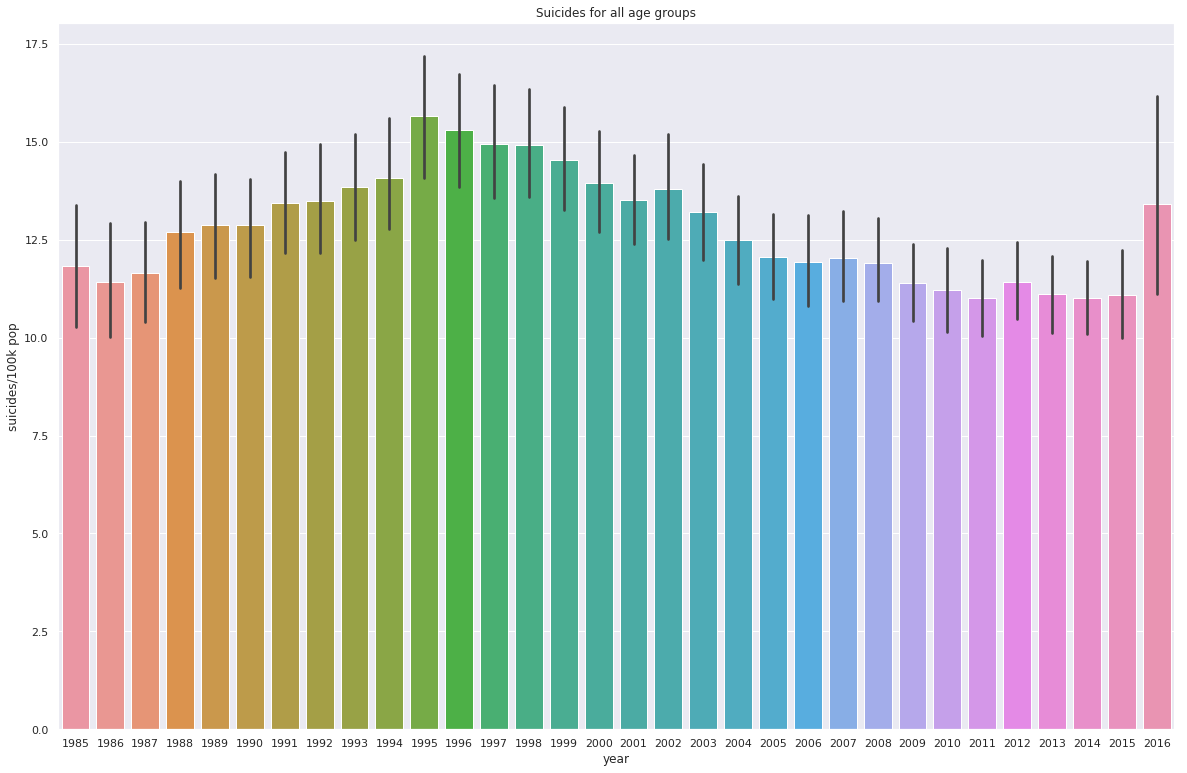

In [51]:
sns.set(rc={'figure.figsize':(20,13)})
ax = sns.barplot(x="year", y="suicides/100k pop",data=suicide)
ax.set_title('Suicides for all age groups')

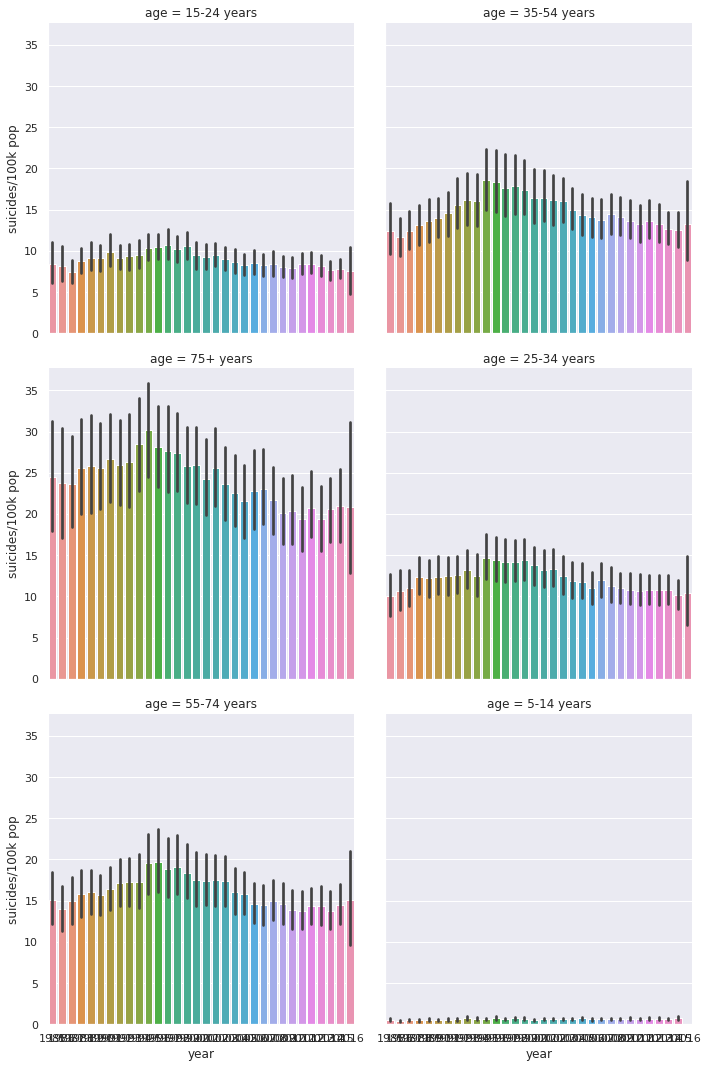

In [52]:
sns.catplot('year','suicides/100k pop',col='age',data=suicide,kind='bar',col_wrap=2)
sns.set(rc={'figure.figsize':(30,13)})

### Visualization 2

In [53]:
from matplotlib.colors import LogNorm

In [54]:
lp = df_processed.toPandas()

In [55]:
lp_p = lp.groupby(['year','age']).suicides_no.sum().reset_index()

In [56]:
lp_p['age'] = lp_p.age.astype(pd.api.types.CategoricalDtype(categories = ['5-14 years','15-24 years','25-34 years','35-54 years','55-74 years','75+ years']))

In [57]:
sns.set(rc={'figure.figsize':(15,10)})

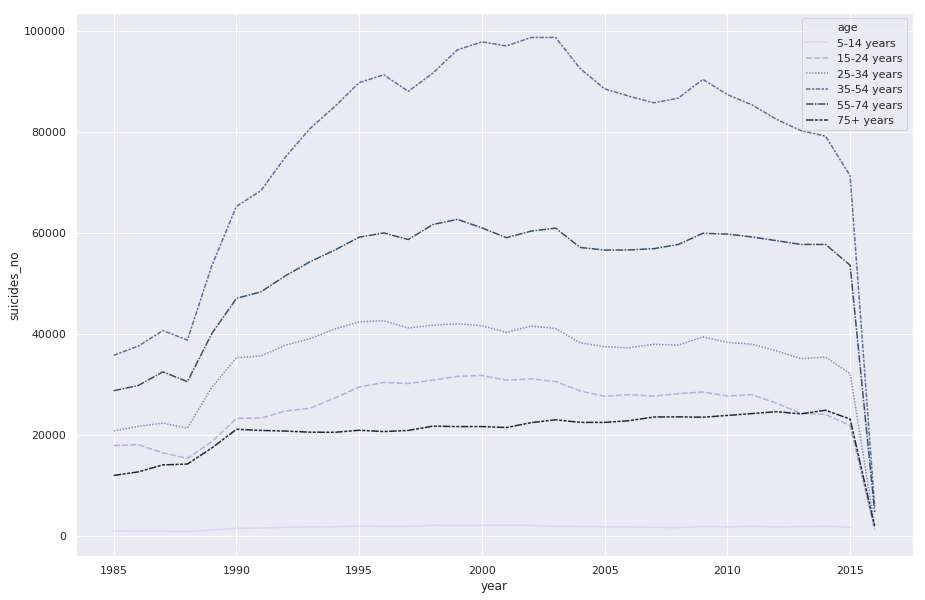

In [58]:
sns.lineplot('year','suicides_no',hue='age',style='age',data=lp_p,hue_norm=LogNorm(),palette="ch:2.5,.25",sort=False)

### Visualization 3

In [59]:
country_year = lp.groupby(['country','year']).agg({'suicides_no':'sum','population':'sum','gdp_per_capita':'median'}).reset_index()

In [60]:
country_year['suicides_100k']=country_year['suicides_no']/country_year['population']*100000

In [61]:
plt.figure(figsize=(15,15))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [62]:
import math
from pyspark.sql.functions import col

In [63]:
lp.gdp_per_capita.astype(float)

0         796.0
1         796.0
2         796.0
3         796.0
4         796.0
5         796.0
6         796.0
7         796.0
8         796.0
9         796.0
10        796.0
11        796.0
12        769.0
13        769.0
14        769.0
15        769.0
16        769.0
17        769.0
18        769.0
19        769.0
20        769.0
21        769.0
22        769.0
23        769.0
24        833.0
25        833.0
26        833.0
27        833.0
28        833.0
29        833.0
          ...  
27790    1964.0
27791    1964.0
27792    1964.0
27793    1964.0
27794    1964.0
27795    1964.0
27796    2150.0
27797    2150.0
27798    2150.0
27799    2150.0
27800    2150.0
27801    2150.0
27802    2150.0
27803    2150.0
27804    2150.0
27805    2150.0
27806    2150.0
27807    2150.0
27808    2309.0
27809    2309.0
27810    2309.0
27811    2309.0
27812    2309.0
27813    2309.0
27814    2309.0
27815    2309.0
27816    2309.0
27817    2309.0
27818    2309.0
27819    2309.0
Name: gdp_per_capita, Le

Text(0.5,1,'Suicide rate per 100k population across gdp per capita')

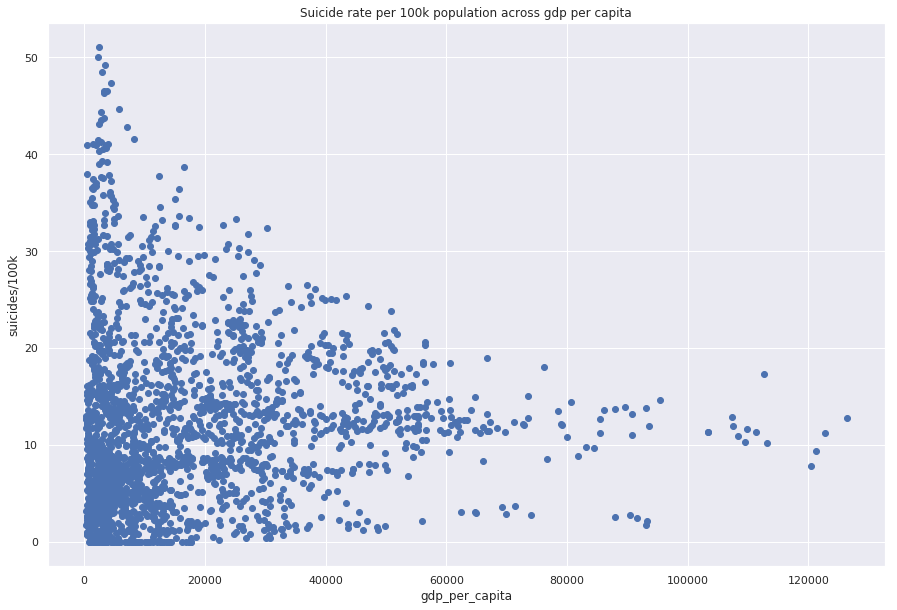

In [64]:
plt.scatter(x=country_year.gdp_per_capita, y=country_year.suicides_100k)
plt.xlabel("gdp_per_capita")
plt.ylabel("suicides/100k")
plt.title('Suicide rate per 100k population across gdp per capita')

# Model Construction

### Main Research Questions:

--- Gain insights of global suicide rate over years through exploratory data analysis     

--- Build models to predict the future suicide rate for the six WHO world regions 

--- Choose the winner model to make the most precise prediction


In [65]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.tree import RandomForest
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.evaluation import RegressionEvaluator

In [66]:
import random
random.seed(123)

In [67]:
import time
import pyspark
import os
import csv
from numpy import array
from pyspark.mllib.regression import LabeledPoint
from pyspark import SparkContext, SparkConf

### 1. Decision Tree Regression

In [68]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [69]:
# Train a DecisionTree model.
dt = DecisionTreeRegressor(labelCol="label", featuresCol="features")

In [70]:
# Train model. 
model = dt.fit(train_data)

In [71]:
# Make predictions.
predictions = model.transform(test_data)

In [72]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_dt = evaluator.evaluate(predictions)

In [73]:
rmse_dt

15.066899570896506

### 2. Random Forest Regression

In [74]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [75]:
# Train a RandomForest model.
rf = RandomForestRegressor(labelCol="label", featuresCol="features")

In [76]:
model = rf.fit(train_data)

In [77]:
predictions= model.transform(test_data)

In [78]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_rf = evaluator.evaluate(predictions)

In [79]:
rmse_rf

15.12060962932502

### 3. Gradient-boosted tree regression    

In [80]:
from pyspark.ml.regression import GBTRegressor

In [81]:
# Train a GBT model.
gbt = GBTRegressor(labelCol="label", featuresCol="features", maxIter=10)

In [82]:
model = gbt.fit(train_data)

In [83]:
predictions= model.transform(test_data)

In [84]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_gbt = evaluator.evaluate(predictions)

In [85]:
rmse_gbt

14.583728898502146

### 4. Linear Regression

In [86]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-14.308768672609885,7.221775197965496,6.425449690187302,4.511536432569709,5.7446944328984095,12.792879179310049,0.4716257591148596,4.916171735307697,-1.3395599549243613,3.0352453224821225,7.303140340813797,3.689109103801656,-3.2094413737091605,2.556675770684565,-3.2068282217833937,-9.308280255235365]
Intercept: 11.016615294972919


In [87]:
predictions= lr_model.transform(test_data)

In [88]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_lr = evaluator.evaluate(predictions)

In [89]:
rmse_lr 

15.718056011812015

# Model Evaluation

In [91]:
#RMSE table
dataFrame = sqlCtx.createDataFrame([
    (rmse_dt, rmse_rf, rmse_gbt, rmse_lr)], 
    ["Decision Tree","Random Forest","Gradient-Boosted Trees","Linear Regression"])

print("RMSE Table")
dataFrame.show()

RMSE Table
+------------------+-----------------+----------------------+------------------+
|     Decision Tree|    Random Forest|Gradient-Boosted Trees| Linear Regression|
+------------------+-----------------+----------------------+------------------+
|15.066899570896506|15.12060962932502|    14.583728898502146|15.718056011812015|
+------------------+-----------------+----------------------+------------------+



### Champion Model: Gradient-Boosted Trees Regression

# References
WHO regions wikipedia